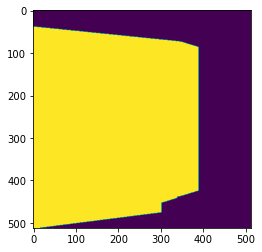

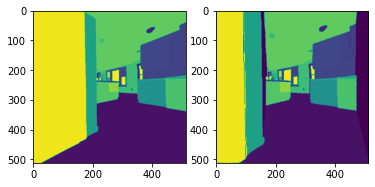

time 0.7600305080413818, acc 0.9858020374286942
src_pose 2.4975655922424522 cur_pose 2.356193663461467, delta 0.0


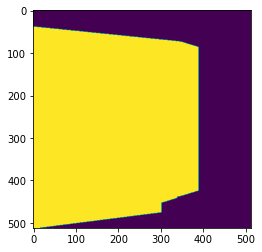

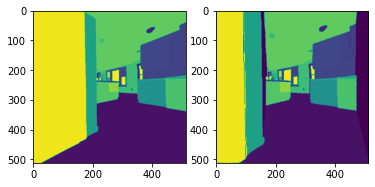

time 0.5159924030303955, acc 0.9858020374286942
src_pose 2.4975655922424522 cur_pose 2.606193663461467, delta 14.32394487827058


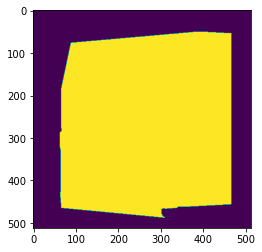

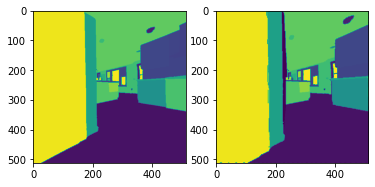

time 0.515528678894043, acc 0.5671821205578572
src_pose 2.4975655922424522 cur_pose 3.106193663461467, delta 28.64788975654116


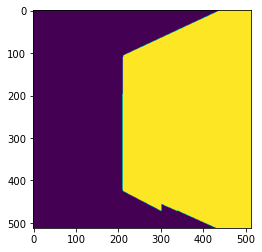

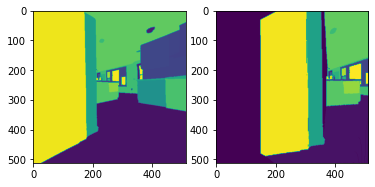

time 0.5192792415618896, acc 0.24684595420792776
src_pose 2.4975655922424522 cur_pose 3.856193663461467, delta 42.97183463481174


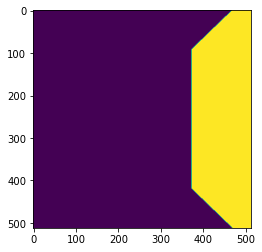

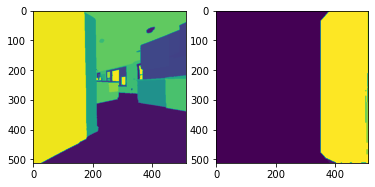

time 0.5158755779266357, acc 0.0024753084899386715
src_pose 2.4975655922424522 cur_pose 4.856193663461466, delta 57.29577951308232


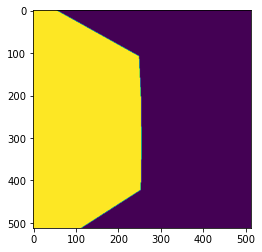

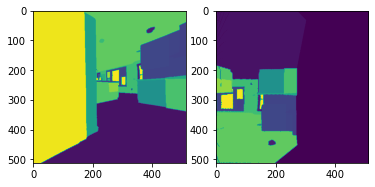

time 0.514826774597168, acc 0.0
src_pose 2.4975655922424522 cur_pose 6.106193663461466, delta 71.6197243913529


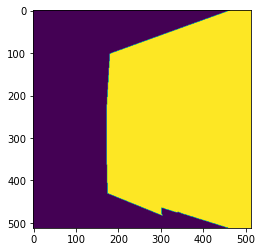

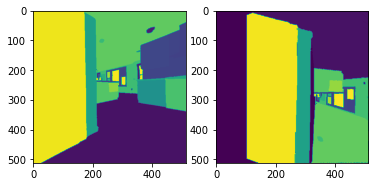

time 0.5156676769256592, acc 2.4576183711888482e-05
src_pose 2.4975655922424522 cur_pose 7.606193663461466, delta 85.94366926962348


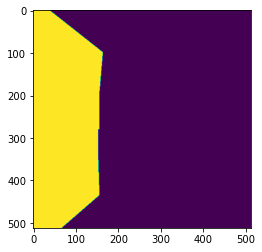

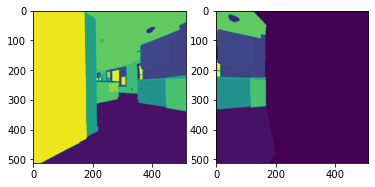

time 0.6742796897888184, acc 0.10251700916011135
src_pose 2.4975655922424522 cur_pose 9.356193663461466, delta 100.26761414789407


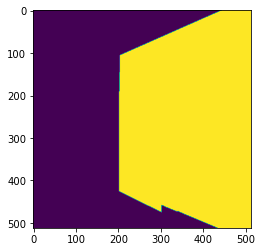

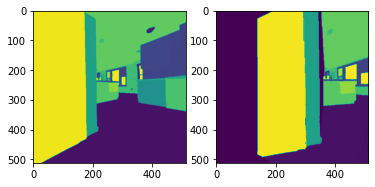

time 0.5145716667175293, acc 0.2544587703209444
src_pose 2.4975655922424522 cur_pose 11.356193663461466, delta 114.59155902616465


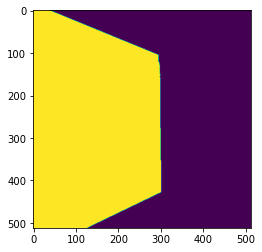

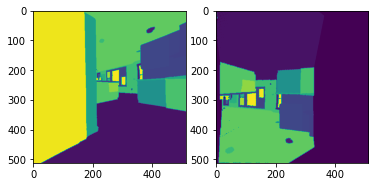

time 0.5063807964324951, acc 1.2300803857532089e-05
src_pose 2.4975655922424522 cur_pose 13.606193663461466, delta 128.91550390443524


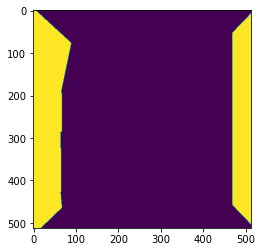

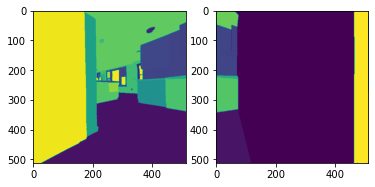

time 0.37961244583129883, acc 0.00884982573117139
src_pose 2.4975655922424522 cur_pose 16.106193663461468, delta 143.2394487827058


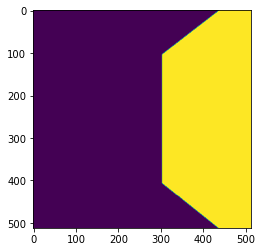

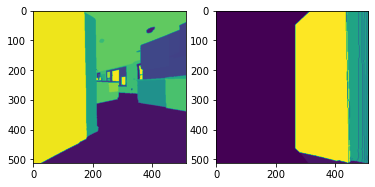

time 0.38578128814697266, acc 0.021604912693611342
src_pose 2.4975655922424522 cur_pose 18.856193663461468, delta 157.56339366097637


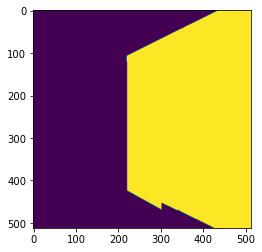

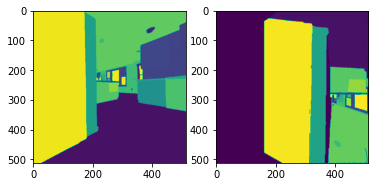

time 0.39048266410827637, acc 0.0


In [73]:
import os
import cv2
import numpy as np
import json
import time
import logging


"""
Copyright (c) Facebook, Inc. and its affiliates.
"""
import numpy as np
import os
import cv2
import json
import glob
from droidlet.lowlevel.robot_mover_utils import transform_pose
from numba import njit
from math import ceil, floor

# Values for locobot in habitat. 
# TODO: generalize this for all robots
fx, fy = 256, 256
cx, cy = 256, 256
intrinsic_mat = np.array([[  fx, 0., cx],
                            [  0., fy, cy],
                            [  0., 0., 1.]])
# rotation from pyrobot to canonical coordinates (https://github.com/facebookresearch/fairo/blob/main/agents/locobot/coordinates.MD)
rot = np.array([[0.0, 0.0, 1.0], [-1.0, 0.0, 0.0], [0.0, -1.0, 0.0]])
CAMERA_HEIGHT = 0.6
trans = np.array([0, 0, CAMERA_HEIGHT])

 # TODO: Consolidate camera intrinsics and their associated utils across locobot and habitat.
def compute_uvone(height, width):
    intrinsic_mat_inv = np.linalg.inv(intrinsic_mat)
    img_resolution = (height, width)
    img_pixs = np.mgrid[0 : img_resolution[0] : 1, 0 : img_resolution[1] : 1]
    img_pixs = img_pixs.reshape(2, -1)
    img_pixs[[0, 1], :] = img_pixs[[1, 0], :]
    uv_one = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))
    uv_one_in_cam = np.dot(intrinsic_mat_inv, uv_one)
    return uv_one_in_cam, intrinsic_mat, rot, trans

def convert_depth_to_pcd(depth, pose, uv_one_in_cam, rot, trans):
    # point cloud in camera frame
    depth = (depth.astype(np.float32) / 1000.0).reshape(-1)
    pts_in_cam = np.multiply(uv_one_in_cam, depth)
    pts_in_cam = np.concatenate((pts_in_cam, np.ones((1, pts_in_cam.shape[1]))), axis=0)
    # point cloud in robot base frame
    pts_in_base = pts_in_cam[:3, :].T
    pts_in_base = np.dot(pts_in_base, rot.T)
    pts_in_base = pts_in_base + trans.reshape(-1)
    # point cloud in world frame (pyrobot)
    pts_in_world = transform_pose(pts_in_base, pose)
    return pts_in_world

@njit
def get_annot(height, width, pts_in_cur_img, src_label):
    """
    This creates the new semantic labels of the projected points in the current image frame. Each new semantic label is the 
    semantic label corresponding to pts_in_cur_img in src_label. 
    """
    annot_img = np.zeros((height, width))
    for indx in range(len(pts_in_cur_img)):
        r = int(indx/width)
        c = int(indx - r*width)
        x, y, _ = pts_in_cur_img[indx]
        
        # We take ceil and floor combinations to fix quantization errors
        if floor(x) >= 0 and ceil(x) < height and floor(y) >=0 and ceil(y) < width:
            annot_img[ceil(y)][ceil(x)] = src_label[r][c]
            annot_img[floor(y)][floor(x)] = src_label[r][c]
            annot_img[ceil(y)][floor(x)] = src_label[r][c]
            annot_img[floor(y)][ceil(x)] = src_label[r][c]
    
    return annot_img

class LabelPropagate:
    def __call__(self,    
        src_img,
        src_depth,
        src_label,
        src_pose,
        cur_pose,
        cur_depth,
    ):
        """
        1. Gets point cloud for the source image 
        2. Transpose the point cloud based on robot location (cur_pose) 
        3. Project the point cloud back into the image frame. The corresponding semantic label for each point from the src_label becomes
        the new semantic label in the current frame.
        Args:
            src_img (np.ndarray): source image to propagte from
            src_depth (np.ndarray): source depth to propagte from
            src_label (np.ndarray): source semantic map to propagte from
            src_pose (np.ndarray): (x,y,theta) of the source image
            cur_pose (np.ndarray): (x,y,theta) of current image
            cur_depth (np.ndarray): current depth
        """

        height, width, _ = src_img.shape
        uv_one_in_cam, intrinsic_mat, rot, trans = compute_uvone(height, width)
        
        pts_in_world = convert_depth_to_pcd(src_depth, src_pose, uv_one_in_cam, rot, trans)
        
        # TODO: can use cur_pts_in_world for filtering. Not needed for baseline.
        # cur_pts_in_world = convert_depth_to_pcd(cur_depth, cur_pose, uv_one_in_cam, rot, trans)
        
        # convert pts_in_world to current base
        pts_in_cur_base = transform_pose(pts_in_world, (-cur_pose[0], -cur_pose[1], 0))
        pts_in_cur_base = transform_pose(pts_in_cur_base, (0.0, 0.0, -cur_pose[2]))

        # conver point from current base to current camera frame
        pts_in_cur_cam = pts_in_cur_base - trans.reshape(-1)
        pts_in_cur_cam = np.dot(pts_in_cur_cam, rot)

        # conver pts in current camera frame into 2D pix values
        pts_in_cur_img = np.matmul(intrinsic_mat, pts_in_cur_cam.T).T
        # print(pts_in_cur_img.shape, pts_in_cur_img[:5])
        
        pts_in_cur_img /= pts_in_cur_img[:, 2].reshape([-1, 1])
        
        # take a mask of all valid indices
        valid_idx = np.logical_and(
            np.logical_and(0 <= pts_in_cur_img[:, 0], pts_in_cur_img[:, 0] < height),
            np.logical_and(0 <= pts_in_cur_img[:, 1], pts_in_cur_img[:, 1] < width),
        ).reshape((512,512))
        # valid_vis = np.zeros((512,512))
        # valid
        plt.imshow(np.flip(valid_idx))
        plt.show()
        
        cur_pts_in_world = convert_depth_to_pcd(cur_depth, cur_pose, uv_one_in_cam, rot, trans)
        
        # print(cur_pts_in_world[:4], pts_in_world[:4])
        
        # print(
        # valid = pts_in_cur_img
        # print(pts_in_cur_img[:5])
        # print(pts_in_cur_img.min(), pts_in_cur_img.max())
        
        return get_annot(height, width, pts_in_cur_img, src_label)

LABEL_PROP_TEST_ASSETS_DIR = '/private/home/apratik/fairo/perception_handlers/label_prop_test_assets'

import matplotlib.pyplot as plt 

class LabelPropTest:
    def __init__(self):
        self.lp = LabelPropagate()
        self.test_assets = LABEL_PROP_TEST_ASSETS_DIR

    def read_test_asset_idx(self, root, img_indx):
        src_img = cv2.imread(os.path.join(root, "rgb_{:05d}.jpg".format(img_indx)))
        src_depth = np.load(os.path.join(root, "depth_{:05d}.npy".format(img_indx)))
        src_label = np.load(os.path.join(root, "seg_{:05d}.npy".format(img_indx)))
        with open(os.path.join(root, "data.json"), "r") as f:
            base_pose_data = json.load(f)
        src_pose = base_pose_data["{}".format(img_indx)]
        
        # Visualize label
        return src_img, src_label, src_depth, src_pose, None
    
    def calculate_accuracy(self, act, pred):
        h, w = act.shape
        assert act.shape == pred.shape
        
        correct = np.sum(act[pred != 0] == pred[pred != 0])
        total = np.sum(pred != 0)
        
        return correct/total
    
    def _run_test(self, data_dir):
        """
        Checks that each label prop call runs in < 0.1 seconds with > 90% accuracy
        """
        for x in os.listdir(data_dir)[-1]:
            dd = os.path.join(data_dir, x)
            
            # Each test asset folder has one source id, and one id to label propagate to
            ids = []
            with open(os.path.join(dd, 'gtids.txt'), 'r') as f:
                ids = f.readlines()
                ids = [int(x.strip()) for x in ids]
                            
            src_img, src_label, src_depth, src_pose, cam_transform = self.read_test_asset_idx(dd, ids[0])
            cur_img, cur_label, cur_depth, cur_pose, cam_transform = self.read_test_asset_idx(dd, ids[1])
            
            # src_depth = np.zeros_like(src_depth)
            # src_depth[100,100] = 2
            
            start = time.time()
            prop_label = self.lp(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)

            fig, axs = plt.subplots(1,2)
            axs[0].imshow(src_label)
            # axs[1].imshow(cur_label)
            axs[1].imshow(prop_label)
            plt.show()

            time_taken = time.time() - start
            acc = self.calculate_accuracy(cur_label, prop_label)
            print(f'time {time_taken}, acc {acc}')
            
            for x in range(0, 60, 5):
                yaw = x/20
                cur_pose[2] += yaw
                print(f'src_pose {src_pose[2]} cur_pose {cur_pose[2]}, delta {math.degrees(yaw)}')
                start = time.time()
                prop_label = self.lp(src_img, src_depth, src_label, src_pose, cur_pose, cur_depth)

                fig, axs = plt.subplots(1,2)
                axs[0].imshow(src_label)
                # axs[1].imshow(cur_label)
                axs[1].imshow(prop_label)
                plt.show()

                time_taken = time.time() - start
                acc = self.calculate_accuracy(cur_label, prop_label)
                print(f'time {time_taken}, acc {acc}')
                # assert acc*100 > 90, f'accuracy {acc} < 90'
        
    def test_label_prop_nonoise(self):
        data_dir = os.path.join(self.test_assets, 'no_noise')
        self._run_test(data_dir)
            
    def test_label_prop_noise(self):
        data_dir = os.path.join(self.test_assets, 'noise')
        self._run_test(data_dir)
        
c = LabelPropTest()
c.test_label_prop_nonoise()